# Machine Learning 2024/2025 - Progress Task 2 (Machine Learning Model Applications and Analysis)

## Introduction

Based on our experience and the previous task, we decided to use Random Forest Classifier as a first approach. It is an ensemble method that trains multiple decision trees and combines them to get a more accurate and stable prediction. It is a good choice for classification tasks and it is easy to use and tune.

## Methodology

Once the data was preprocessed, we split it into training and testing sets. To find the best hyperparameters, we used RandomizedSearchCV, which is a method that randomly selects a set of hyperparameters from a grid and evaluates them using cross-validation. We decided to use this method because it is faster than GridSearchCV and we will be executing the code multiple times.

To make different tests and save the performance of each model, we have used a tool called MLFlow. That allows to track the performance of the models, save the models in a file and compare them easily.

## Implementation

In [1]:
# import libraries
import pandas as pd
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt

First we need to take the data. We have a class called Dataset that is responsible for loading the data and make some preprocessing. From now on, we will use the whole dataset that was exported to csv in `Preprocessing.ipynb` without making any other preprocessing, like removing the correlated features.

In [2]:
# import dataset
from mlflow.create_dataset import Dataset

data = Dataset()
X, y, output = data.with_correlation()

A single Random Forest model can't be used in an multi-class classification problem. Therefore, we need `sklearn.multioutput.MultiOutputClassifier` to fit one classifier per target. We did not used a random state value, as we wanted to perform multiple tests, therefore this experiment is not reproducible.

In [3]:
# initialize model
model_to_train = MultiOutputClassifier(RandomForestClassifier(warm_start=True), n_jobs=-1)

In [4]:
# initialize search hyperparameters
param_dist_random = {
                'estimator__n_estimators': randint(50, 200),
                'estimator__max_depth': [None, 10, 20, 30],
                'estimator__min_samples_split': randint(2, 11),
                'estimator__min_samples_leaf': randint(1, 5),
                'estimator__criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist_random,
                                    n_iter=100, cv=5, n_jobs=-1, verbose=1,
                                    scoring='roc_auc')

In [5]:
# create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #no random state

All the preparation steps have been done and now we can start the training and evaluation process.

In [6]:
#train the model
# WARNING time: 11 min
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by random search:', random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found by random search: {'estimator__criterion': 'entropy', 'estimator__max_depth': 20, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 9, 'estimator__n_estimators': 169}


In [7]:
# predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

In [8]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

Accuracy: 0.6842006739049046
ROC AUC: 0.7415120521195204
F1: 0.6620609540838549


--> TODO: include comments?

In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.45      0.57      1135
           1       0.78      0.74      0.76      2488

   micro avg       0.78      0.65      0.71      3623
   macro avg       0.77      0.59      0.66      3623
weighted avg       0.77      0.65      0.70      3623
 samples avg       0.34      0.32      0.33      3623



After testing the performance of a simple Random Forest using the previous approach, we got a ROC AUC score of 0.8533, which is a really good result, approximately at ranking 800. We thought that we could improve this result by retraing the model.

Taking a look at the documentation of [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), we found that the parameter `warm_start` can be used to reuse the solution of the previous call to fit and add more estimators to the ensemble. So following an approach similar to Neural Networks, we decided to train the model in multiple steps, adding 50 estimators each time and implementing a early stopping mechanism in a naive way. The reason for adding more estimators is that the model can learn more complex patterns and generalize better at each epoch.

However, there's a risk that the model overfits the training data, so we need to evaluate the model in the validation set after each epoch and stop the training if the performance is not improving. We will use the ROC AUC score as the metric to evaluate the model.

In [10]:
m = best_model #current best model for worse performance

prev_val = roc_auc
for i in range(50):
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred, average="macro")
    if prev_val > roc_auc: # model is not improving
        continue
    print(f'Iteration {i+1} - ROC AUC: {roc_auc}')
    if roc_auc - prev_val < 0.0001:
        print(f'Early stopping at iteration {i+1}')
        break
    m.estimator.n_estimators += 50
    prev_val = roc_auc

Iteration 1 - ROC AUC: 0.7434179243233554
Iteration 3 - ROC AUC: 0.7437132865908533
Iteration 6 - ROC AUC: 0.7440493290255644
Iteration 40 - ROC AUC: 0.7440740998009826
Early stopping at iteration 40


Now we are going to evaluate it again.

In [ ]:
################ METRICS ################
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'F1: {f1}')

In [ ]:
# confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred[:, 0], normalize='all')
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
disp_h1n1.plot(ax=ax[0], colorbar=False)
ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

# Confusion matrix for seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred[:, 1], normalize='all')
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
disp_seasonal.plot(ax=ax[1], colorbar=False)
ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

plt.tight_layout()
plt.show()

In [ ]:
y_scores = [p[:, 1] for p in y_pred_proba]

plt.figure(figsize=(7, 5))
for i, y_score in enumerate(y_scores):
    fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
    auc = roc_auc_score(y_test.iloc[:, i], y_score)
    plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Submission

In [11]:
# competition submission
predictions = best_model.predict_proba(output)
        
h1n1_probs = predictions[0][:, 1]  # Probabilities of positive class for h1n1_vaccine
seasonal_probs = predictions[1][:, 1]  # Probabilities of positive class for seasonal_vaccine
predict = pd.DataFrame({
            "respondent_id": output.index,
            "h1n1_vaccine": h1n1_probs,
            "seasonal_vaccine": seasonal_probs
})
predict.set_index("respondent_id", inplace=True)
predict.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.177913,0.259646
26708,0.041745,0.038087
26709,0.256132,0.800002
26710,0.623692,0.906221
26711,0.326017,0.462796


Uncomment the following cell to save the results on an csv file to upload it to the competition.

In [12]:
# predict.to_csv("predictions.csv")

## Results

As we said previously, this experiment is not reproducible. However, we have saved the results of the models in MLFlow. Here are the results of the best model:

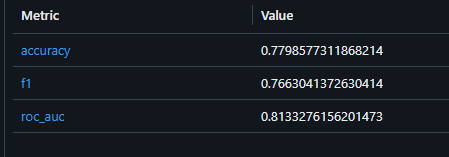

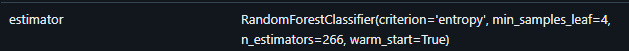

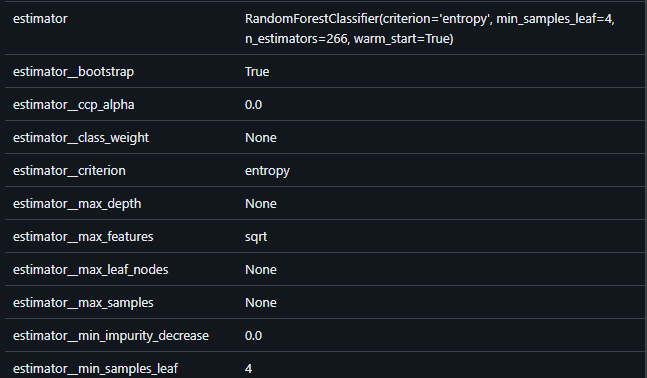  
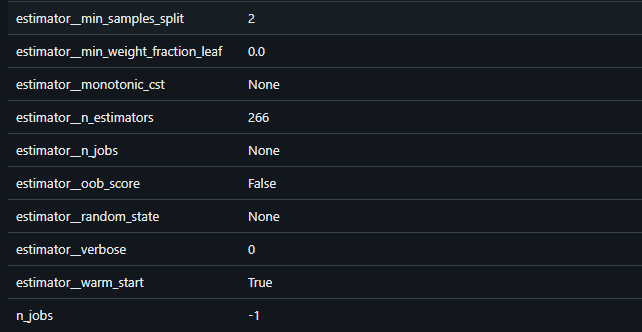

It is worth mentioning that every Random Forest model we trained had a ROC AUC score between 0.7321 and 0.7562, except for the previous one, which had a score of 0.8133. Retraining the model improved slightly the score but it highly depend on the first model. If it was a good one, it was easier and faster to get a better score.

Here are other runs that we have made:  
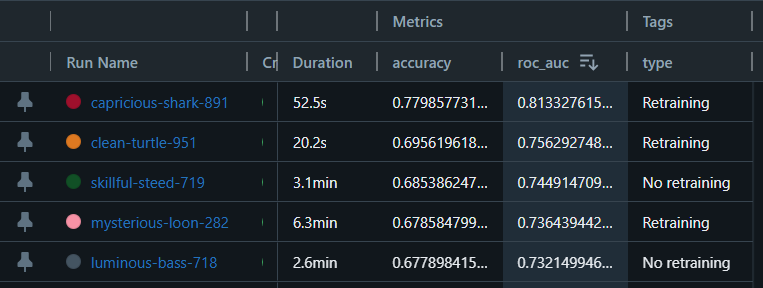

Some models with no retraining had a better performance than a retrained model, as we have mentioned before. 

Note: It's curious how both the first and second runs were made with the same model but different train-test splits, that could explain the difference in the performance. In `clean-turtle-951` we trained the model and got a ROC AUC score of 0.7562, which was the best score and similar to other runs. However, we didn't record the parameters so we had to make another run, which corresponds to `capricious-shark-891`, where the score was 0.8133. This upgrade in performance might be influenced by instances of the new test set that were previoulsy in the training set. This means, the model is being evaluated with instances that it has already seen so the performance is better.

## Results on the competition

Our firsts approaches with Random Forest Classifier with optimized hyperparameters with Random Search showed a really good performance with an score of 0.8520 and a ranking of around 800. Our seacond try with retraining got a higher score.

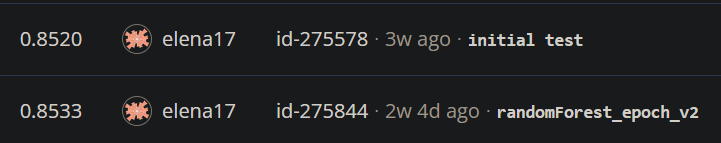

We made some other tests with Random Forest, changing the code, the hyperparameters search and some preprocessing steps but they were not successful. Here's the result of the best one:

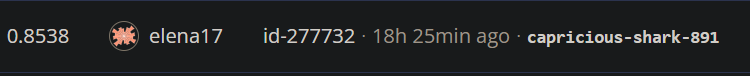